https://tutorials.pytorch.kr/beginner/Intro_to_TorchScript_tutorial.html

In [1]:
import torch
import torch.nn as nn

In [2]:
class MyCell(torch.nn.Module):
    def __init__(self):
        super(MyCell, self).__init__()

    def forward(self, x, h):
        new_h = torch.tanh(x + h)
        return new_h, new_h

my_cell = MyCell()
x = torch.rand(3, 4)
h = torch.rand(3, 4)
print(my_cell(x, h))

(tensor([[0.7030, 0.8974, 0.9540, 0.8349],
        [0.8650, 0.5972, 0.7922, 0.7926],
        [0.4679, 0.7265, 0.7734, 0.8631]]), tensor([[0.7030, 0.8974, 0.9540, 0.8349],
        [0.8650, 0.5972, 0.7922, 0.7926],
        [0.4679, 0.7265, 0.7734, 0.8631]]))


In [9]:
class MyCell(torch.nn.Module):
    def __init__(self):
        super(MyCell, self).__init__()
        self.linear = torch.nn.Linear(4, 4)

    def forward(self, x, h):
        print("========", x.shape, "========")
        new_h = torch.tanh(self.linear(x) + h)
        return new_h, new_h

my_cell = MyCell()
print(my_cell)
print(my_cell(x, h))

MyCell(
  (linear): Linear(in_features=4, out_features=4, bias=True)
)
======== torch.Size([3, 4]) ========
(tensor([[-0.0374,  0.6949,  0.4374,  0.0937],
        [ 0.2005,  0.6866,  0.2470, -0.0928],
        [-0.0085,  0.4037,  0.7731,  0.1212]], grad_fn=<TanhBackward>), tensor([[-0.0374,  0.6949,  0.4374,  0.0937],
        [ 0.2005,  0.6866,  0.2470, -0.0928],
        [-0.0085,  0.4037,  0.7731,  0.1212]], grad_fn=<TanhBackward>))


In [4]:
class MyDecisionGate(torch.nn.Module):
    def forward(self, x):
        if x.sum() > 0:
            return x
        else:
            return -x

class MyCell(torch.nn.Module):
    def __init__(self):
        super(MyCell, self).__init__()
        self.dg = MyDecisionGate()
        self.linear = torch.nn.Linear(4, 4)

    def forward(self, x, h):
        new_h = torch.tanh(self.dg(self.linear(x)) + h)
        return new_h, new_h

my_cell = MyCell()
print(my_cell)
print(my_cell(x, h))

MyCell(
  (dg): MyDecisionGate()
  (linear): Linear(in_features=4, out_features=4, bias=True)
)
(tensor([[ 0.4594,  0.3221,  0.9233,  0.8122],
        [ 0.9474, -0.1538,  0.9034,  0.4820],
        [ 0.3863,  0.5244,  0.7410,  0.9110]], grad_fn=<TanhBackward>), tensor([[ 0.4594,  0.3221,  0.9233,  0.8122],
        [ 0.9474, -0.1538,  0.9034,  0.4820],
        [ 0.3863,  0.5244,  0.7410,  0.9110]], grad_fn=<TanhBackward>))


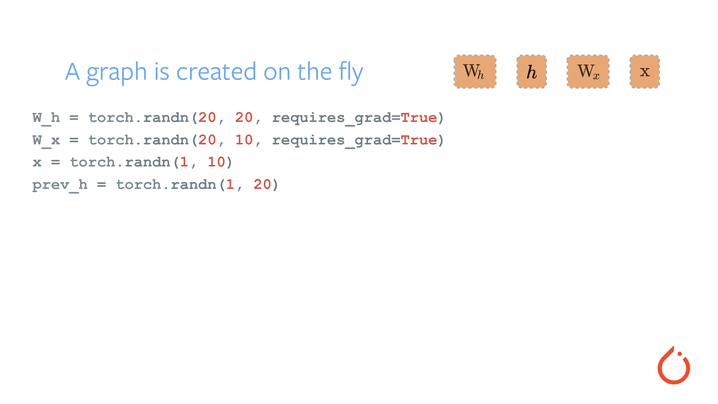

In [20]:
class MyCell(torch.nn.Module):
    def __init__(self):
        super(MyCell, self).__init__()
        self.linear = torch.nn.Linear(4, 4)

    def forward(self, x, h):
#         print("========", x.shape, "========")
        new_h = torch.tanh(self.linear(x) + h)
        return new_h, new_h

my_cell = MyCell()
x, h = torch.rand(3, 4), torch.rand(3, 4)
traced_cell = torch.jit.trace(my_cell, (x, h))
print("=====\n", traced_cell)
traced_cell(x, h)

=====
 MyCell(
  original_name=MyCell
  (linear): Linear(original_name=Linear)
)


(tensor([[-0.4097,  0.2220,  0.9551,  0.7145],
         [ 0.1614,  0.5304,  0.7981,  0.6158],
         [ 0.1606,  0.7048,  0.6296,  0.7074]], grad_fn=<TanhBackward>),
 tensor([[-0.4097,  0.2220,  0.9551,  0.7145],
         [ 0.1614,  0.5304,  0.7981,  0.6158],
         [ 0.1606,  0.7048,  0.6296,  0.7074]], grad_fn=<TanhBackward>))

In [21]:
traced_cell.graph

graph(%self.1 : __torch__.___torch_mangle_31.MyCell,
      %input : Float(3:4, 4:1, requires_grad=0, device=cpu),
      %h : Float(3:4, 4:1, requires_grad=0, device=cpu)):
  %19 : __torch__.torch.nn.modules.linear.___torch_mangle_30.Linear = prim::GetAttr[name="linear"](%self.1)
  %21 : Tensor = prim::CallMethod[name="forward"](%19, %input)
  %12 : int = prim::Constant[value=1]() # <ipython-input-20-7c230545201a>:8:0
  %13 : Float(3:4, 4:1, requires_grad=1, device=cpu) = aten::add(%21, %h, %12) # <ipython-input-20-7c230545201a>:8:0
  %14 : Float(3:4, 4:1, requires_grad=1, device=cpu) = aten::tanh(%13) # <ipython-input-20-7c230545201a>:8:0
  %15 : (Float(3:4, 4:1, requires_grad=1, device=cpu), Float(3:4, 4:1, requires_grad=1, device=cpu)) = prim::TupleConstruct(%14, %14)
  return (%15)

In [22]:
traced_cell.code

'def forward(self,\n    input: Tensor,\n    h: Tensor) -> Tuple[Tensor, Tensor]:\n  _0 = torch.add((self.linear).forward(input, ), h, alpha=1)\n  _1 = torch.tanh(_0)\n  return (_1, _1)\n'

In [23]:
class MyCell(torch.nn.Module):
    def __init__(self):
        super(MyCell, self).__init__()
        self.linear = torch.nn.Linear(4, 4)

    def forward(self, x, h):
        print("========", x.shape, "========")
        new_h = torch.tanh(self.linear(x) + h)
        return new_h, new_h

my_cell = MyCell()
x, h = torch.rand(3, 4), torch.rand(3, 4)
traced_cell = torch.jit.trace(my_cell, (x, h))
print("=====\n", traced_cell)
traced_cell(x, h)

======== torch.Size([3, 4]) ========
======== torch.Size([3, 4]) ========
======== torch.Size([3, 4]) ========
=====
 MyCell(
  original_name=MyCell
  (linear): Linear(original_name=Linear)
)


C:\Users\jinma\AppData\Local\Continuum\anaconda3\envs\basic\lib\site-packages\ipykernel_launcher.py:7: TracerWarning: Converting a tensor to a Python integer might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  import sys


(tensor([[ 0.8843, -0.1099,  0.9226,  0.8271],
         [ 0.6290,  0.2328,  0.3915,  0.6427],
         [ 0.5528,  0.0395,  0.4873,  0.2719]], grad_fn=<TanhBackward>),
 tensor([[ 0.8843, -0.1099,  0.9226,  0.8271],
         [ 0.6290,  0.2328,  0.3915,  0.6427],
         [ 0.5528,  0.0395,  0.4873,  0.2719]], grad_fn=<TanhBackward>))

In [24]:
traced_cell.graph

graph(%self.1 : __torch__.___torch_mangle_35.MyCell,
      %x : Float(3:4, 4:1, requires_grad=0, device=cpu),
      %h : Float(3:4, 4:1, requires_grad=0, device=cpu)):
  %25 : __torch__.torch.nn.modules.linear.___torch_mangle_34.Linear = prim::GetAttr[name="linear"](%self.1)
  %27 : Tensor = prim::CallMethod[name="forward"](%25, %x)
  %18 : int = prim::Constant[value=1]() # <ipython-input-23-87f3fa9fc37c>:8:0
  %19 : Float(3:4, 4:1, requires_grad=1, device=cpu) = aten::add(%27, %h, %18) # <ipython-input-23-87f3fa9fc37c>:8:0
  %20 : Float(3:4, 4:1, requires_grad=1, device=cpu) = aten::tanh(%19) # <ipython-input-23-87f3fa9fc37c>:8:0
  %21 : (Float(3:4, 4:1, requires_grad=1, device=cpu), Float(3:4, 4:1, requires_grad=1, device=cpu)) = prim::TupleConstruct(%20, %20)
  return (%21)

In [25]:
traced_cell.code

'def forward(self,\n    x: Tensor,\n    h: Tensor) -> Tuple[Tensor, Tensor]:\n  _0 = torch.add((self.linear).forward(x, ), h, alpha=1)\n  _1 = torch.tanh(_0)\n  return (_1, _1)\n'

# torch jit

In [1]:
import torch
import torch.nn as nn

In [2]:
class RNNEncoder(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.rnn = nn.LSTM(10, 10)
        
    def forward(self, x):
        return self.rnn(x)
    
    def _flatten(self, module):
        module.flatten_parameters()

In [3]:
net = RNNEncoder()

In [5]:
net._flatten(net.rnn)

In [6]:
m = torch.jit.script(net)
m

RecursiveScriptModule(
  original_name=RNNEncoder
  (rnn): RecursiveScriptModule(original_name=LSTM)
)

In [7]:
m.code

'def forward(self,\n    x: Tensor) -> Tuple[Tensor, Tuple[Tensor, Tensor]]:\n  return (self.rnn).forward__0(x, None, )\n'

In [8]:
m.graph

graph(%self : __torch__.RNNEncoder,
      %x.1 : Tensor):
  %4 : None = prim::Constant()
  %2 : __torch__.torch.nn.modules.rnn.LSTM = prim::GetAttr[name="rnn"](%self)
  %5 : (Tensor, (Tensor, Tensor)) = prim::CallMethod[name="forward__0"](%2, %x.1, %4) # <ipython-input-2-801d042a87dd>:8:15
  return (%5)

In [9]:
with torch.no_grad():
    torch.jit.save(m, "./test.pt", _extra_files={"foo.txt": "hello, wolrd!"})

In [10]:
loaded_model = torch.jit.load("test.pt")
loaded_model

RecursiveScriptModule(
  original_name=RNNEncoder
  (rnn): RecursiveScriptModule(original_name=LSTM)
)

In [11]:
import io

In [12]:
with open("test.pt", "rb") as f:
    buffer = io.BytesIO(f.read())

buffer

In [13]:
torch.jit.load(buffer)

RecursiveScriptModule(
  original_name=RNNEncoder
  (rnn): RecursiveScriptModule(original_name=LSTM)
)

In [14]:
buffer.seek(0)

0

In [15]:
torch.jit.load(buffer, map_location=torch.device("cpu"))

RecursiveScriptModule(
  original_name=RNNEncoder
  (rnn): RecursiveScriptModule(original_name=LSTM)
)

In [16]:
extra_files = {"foo.txt": ""}
model = torch.jit.load("test.pt", _extra_files=extra_files, map_location="cuda")

In [17]:
model

RecursiveScriptModule(
  original_name=RNNEncoder
  (rnn): RecursiveScriptModule(original_name=LSTM)
)

In [18]:
extra_files

{'foo.txt': b'hello, wolrd!'}

In [19]:
model(torch.randn(3, 10, 10).cuda())

C:\Users\jinma\AppData\Local\Continuum\anaconda3\envs\basic\lib\site-packages\torch\nn\modules\module.py:727: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  ..\aten\src\ATen\native\cudnn\RNN.cpp:775.)
  result = self.forward(*input, **kwargs)


(tensor([[[-8.9471e-02, -1.6178e-01,  3.3192e-02, -1.1226e-01,  2.0533e-01,
           -5.5598e-02,  2.0012e-02, -1.1687e-01,  2.1392e-01,  8.1119e-02],
          [ 8.8651e-02, -5.9045e-02, -1.6378e-01, -8.8476e-02, -2.0625e-01,
           -1.1447e-02,  3.1051e-01, -1.1021e-01, -1.1563e-01, -8.1187e-02],
          [ 1.2550e-01, -1.0441e-01, -1.9398e-01,  1.0354e-01, -5.8592e-02,
           -2.6434e-03, -5.0872e-02,  1.3510e-01, -2.2532e-01,  3.3664e-01],
          [ 1.1036e-03, -9.6111e-02,  1.2476e-01, -9.9809e-02,  1.2856e-01,
           -5.6992e-02,  2.6332e-01, -1.0498e-01, -1.5976e-01,  1.4029e-01],
          [-2.0505e-01, -1.8576e-01,  9.5481e-02, -1.3039e-01,  2.7985e-01,
           -1.8683e-01, -1.4580e-01, -1.2861e-01,  4.7859e-01,  1.7279e-01],
          [-3.0085e-01, -1.4365e-01,  3.6062e-02, -2.9153e-02,  2.8062e-01,
           -1.2775e-01,  2.4136e-03,  5.3624e-02, -1.0710e-01,  1.7487e-01],
          [-1.5033e-01,  1.0031e-01, -5.8056e-02, -6.8878e-03, -9.5533e-02,
      

# BERT JIT Example
- https://towardsdatascience.com/pytorch-jit-and-torchscript-c2a77bac0fff

In [20]:
from transformers import BertTokenizer, BertModel
import numpy as np
import torch
from time import perf_counter

def timer(f,*args):   
    
    start = perf_counter()
    f(*args)
    return (1000 * (perf_counter() - start))

In [21]:
script_tokenizer = BertTokenizer.from_pretrained(
    'bert-base-uncased', torchscript=True)
script_model = BertModel.from_pretrained(
    "bert-base-uncased", torchscript=True)

In [36]:
# Tokenizing input text
text = "[CLS] Who was Jim Henson ? [SEP] Jim Henson was a puppeteer [SEP]"
tokenized_text = script_tokenizer.tokenize(text)

# Masking one of the input tokens
masked_index = 8

tokenized_text[masked_index] = '[MASK]'

indexed_tokens = script_tokenizer.convert_tokens_to_ids(tokenized_text)

segments_ids = [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1]

# Creating a dummy input
tokens_tensor = torch.tensor([indexed_tokens])
segments_tensors = torch.tensor([segments_ids])

In [37]:
type(script_model)

transformers.models.bert.modeling_bert.BertModel

In [38]:
# Example 1.1 BERT on CPU

native_model = BertModel.from_pretrained("bert-base-uncased")
np.mean(
    [timer(native_model,tokens_tensor,segments_tensors) for _ in range(100)]
)

40.593244000001505

In [39]:
# Example 1.2 BERT on GPU
# Both sample data model need be on the GPU device for the inference to take place
native_gpu = native_model.cuda()
tokens_tensor_gpu = tokens_tensor.cuda()
segments_tensors_gpu = segments_tensors.cuda()
np.mean(
    [timer(native_gpu,tokens_tensor_gpu,segments_tensors_gpu) for _ in range(100)]
)

14.413136999996823

In [40]:
# Example 2.1 torch.jit.trace on CPU

traced_model = torch.jit.trace(script_model, [tokens_tensor, segments_tensors])

np.mean(
    [timer(traced_model,tokens_tensor,segments_tensors) for _ in range(100)]
)

RuntimeError: Input, output and indices must be on the current device

In [ ]:
# Example 2.2 torch.jit.trace on GPU

traced_model_gpu = torch.jit.trace(script_model.cuda(), [tokens_tensor.cuda(), segments_tensors.cuda()])

np.mean(
    [timer(traced_model_gpu,tokens_tensor.cuda(),segments_tensors.cuda()) for _ in range(100)]
)